# Gaussian Field Simulation Pipeline

Generate the synthetic Gaussian random fields used throughout the anisotropy study. The notebook configures the gstools covariance model, samples multiple realizations per design point, extracts contour-level measurements, and saves the resulting statistics for later analysis in `notebook_paper.ipynb`.

In [ ]:
# Core dependencies for the simulation workflow.
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
import seaborn as sns
import matplotlib.lines as mlines  # Supports bespoke legend entries
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import brentq
from scipy.stats import norm, chi2
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from skimage.measure import euler_number, label
from tqdm.auto import tqdm 
# np.random.seed(31415926)  # Uncomment for deterministic experiments.

# Align Matplotlib/Seaborn styling with the analysis notebook.
sns.set_theme(context='paper', font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.set_style()

# Helper: retrieve contour geometry (perimeters, normals, equispaced points) without rendering figures.
def get_contour_properties(gsfield, level=0, total_target_points=int(1e7)):
    """
    Return normals, perimeters, equispaced points, and allocation counts for the contours of `gsfield` at `level`.
    Points are apportioned proportionally to contour lengths so that ∑ points ≈ total_target_points.
    """
    # Rely on Matplotlib to extract contour segments without rendering a figure.
    cs = plt.contour(gsfield, levels=[level])
    all_segments_paths = []
    if cs.allsegs and cs.allsegs[0]:
        all_segments_paths = cs.allsegs[0]
    plt.close()  # Close the figure to prevent leaking handles.

    all_normals = []
    equispaced_points_coords = []
    total_perimeter = 0
    points_per_path_actual = [] 

    if not all_segments_paths:
        return [], 0, [], []

    # Measure each path length to distribute points proportionally.
    path_lengths = []
    for path in all_segments_paths:
        if len(path) < 2:
            path_lengths.append(0)
            continue
        lengths = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
        current_path_length = np.sum(lengths)
        path_lengths.append(current_path_length)
        total_perimeter += current_path_length

    if total_perimeter == 0:
        points_per_path_actual = [0] * len(all_segments_paths)
        return [], 0, [], points_per_path_actual
    
    # Ideal (non-integer) allocation of points per path based on relative length.
    num_points_ideal_float = []
    for length in path_lengths:
        proportion = length / total_perimeter if total_perimeter > 0 else 0
        num_points_ideal_float.append(proportion * total_target_points)

    points_per_path_actual = [int(np.floor(n)) for n in num_points_ideal_float]
    
    # Guarantee that sufficiently long paths get at least two samples when feasible.
    for i_path in range(len(points_per_path_actual)):
        if num_points_ideal_float[i_path] > 0.5 and points_per_path_actual[i_path] < 2 and len(all_segments_paths[i_path]) >= 2:
            points_per_path_actual[i_path] = 2
        elif len(all_segments_paths[i_path]) < 2:
             points_per_path_actual[i_path] = 0

    # Assign leftover points by descending fractional remainder to reach total_target_points.
    current_sum_points = sum(points_per_path_actual)
    remainder_points = total_target_points - current_sum_points
    
    if remainder_points > 0:
        fractional_parts = [n - np.floor(n) for n in num_points_ideal_float]
        sorted_indices = np.argsort(fractional_parts)[::-1]
        
        for i in range(int(remainder_points)):
            path_idx_to_increment = sorted_indices[i % len(sorted_indices)]
            if len(all_segments_paths[path_idx_to_increment]) >= 2:
                 points_per_path_actual[path_idx_to_increment] += 1

    # Clear allocations on degenerate paths (zero length or single vertex).
    for i_path in range(len(points_per_path_actual)):
        if points_per_path_actual[i_path] > 0 and (len(all_segments_paths[i_path]) < 2 or path_lengths[i_path] == 0):
            points_per_path_actual[i_path] = 0

    # Generate equispaced samples and normals along each contour.
    for i_path, path_coords in enumerate(all_segments_paths):
        num_points_this_path = points_per_path_actual[i_path]

        if num_points_this_path < 2:
            continue  # Skip paths without enough vertices to define normals.
        
        seg_lengths = np.sqrt(np.sum(np.diff(path_coords, axis=0)**2, axis=1))
        cumulative_lengths = np.concatenate(([0], np.cumsum(seg_lengths)))
        
        if cumulative_lengths[-1] == 0:
            continue

        target_distances = np.linspace(0, cumulative_lengths[-1], num_points_this_path, endpoint=True) 
        # When only two points are placed, pin them to the path endpoints for clarity.
        if num_points_this_path == 2 and cumulative_lengths[-1] > 0:
             target_distances = np.array([0, cumulative_lengths[-1]])

        for dist_idx, dist in enumerate(target_distances):
            dist = min(dist, cumulative_lengths[-1])
            dist = max(dist, 0)

            seg_idx = np.searchsorted(cumulative_lengths, dist, side='right') - 1
            seg_idx = max(0, seg_idx) 
            
            if seg_idx >= len(seg_lengths): 
                seg_idx = len(seg_lengths) -1

            pt_A = path_coords[seg_idx]
            pt_B = path_coords[seg_idx + 1] 
            
            dist_along_segment = dist - cumulative_lengths[seg_idx]
            current_segment_length = seg_lengths[seg_idx] if seg_idx < len(seg_lengths) else 0
            
            if current_segment_length == 0:
                if dist >= cumulative_lengths[seg_idx+1] if seg_idx + 1 < len(cumulative_lengths) else cumulative_lengths[-1]:
                    x_p, y_p = pt_B[0], pt_B[1]
                else:
                    x_p, y_p = pt_A[0], pt_A[1]
            else:
                ratio = dist_along_segment / current_segment_length
                x_p = pt_A[0] + ratio * (pt_B[0] - pt_A[0])
                y_p = pt_A[1] + ratio * (pt_B[1] - pt_A[1])
            
            equispaced_points_coords.append(np.array([x_p, y_p]))
            
            # Normal vector is obtained via the clockwise rotation of the tangent.
            dx_tangent = pt_B[0] - pt_A[0]
            dy_tangent = pt_B[1] - pt_A[1]
            nx = -dy_tangent
            ny = dx_tangent
            norm_magnitude = np.sqrt(nx**2 + ny**2)
            
            if norm_magnitude > 1e-9:
                nx /= norm_magnitude
                ny /= norm_magnitude
            else:
                if all_normals:
                    nx, ny = all_normals[-1]
                elif len(path_coords) > seg_idx + 2 :
                    pt_C = path_coords[seg_idx + 2]
                    dx_tangent = pt_C[0] - pt_B[0]
                    dy_tangent = pt_C[1] - pt_B[1]
                    nx = -dy_tangent
                    ny = dx_tangent
                    norm_magnitude = np.sqrt(nx**2 + ny**2)
                    if norm_magnitude > 1e-9:
                        nx /= norm_magnitude
                        ny /= norm_magnitude
                    else:
                        nx, ny = 0, 0
                else:
                    nx, ny = 0, 0
            all_normals.append((nx, ny))

    return all_normals, total_perimeter, equispaced_points_coords, points_per_path_actual

In [ ]:
# Helper: gradient computation expressed in physical units
def compute_gradient_field(gsfield: np.ndarray, spacing: float) -> tuple[np.ndarray, np.ndarray]:
    """Return ∂Z/∂x and ∂Z/∂y arrays scaled by the physical spacing between pixels.

    Notes:
    - spacing equals gstools_model_rescale_factor (= 1 / unit_length) along both axes.
    - np.gradient yields (dZ/dy, dZ/dx) for 2D arrays, so swap the outputs before returning.
    - edge_order=2 applies a higher-accuracy centered stencil.
    """
    if not isinstance(gsfield, np.ndarray) or gsfield.ndim != 2:
        raise ValueError("gsfield must be a 2D numpy array")
    gy, gx = np.gradient(gsfield, spacing, spacing, edge_order=2)
    return gx, gy

In [39]:
# Model parameters and geometric configuration
kappa = 0.5 # Kappa parameter (0 < kappa < 1) driving anisotropy
a_parameter = (1 / (1-kappa**2))**(1/4) # Rescaling factor derived from kappa
print("kappa = ", kappa)
print("a_parameter = ", a_parameter)

field_size = 1000 # Grid size (pixels per axis)
unit_length = 5 # Physical unit spans this many pixels along each axis
T_parameter = field_size / unit_length # Observation window size expressed in physical units
print("T_parameter = ", T_parameter)

gstools_model_rescale_factor = 1/unit_length # Spatial rescaling applied to each coordinate
gstools_model_len_scale = np.sqrt(2) * np.array([a_parameter, 1/a_parameter]) # Principal correlation lengths of the covariance model
# Rotation applied to the covariance matrix
gstools_model_anis_ratio = a_parameter**(-2) # Anisotropy ratio parameter passed to gstools
angle_rad = 1 # Rotation angle (radians)
print("theta = ", angle_rad)

level_val = 1   # Level set under study
print("level_val = ", level_val)

min_length = unit_length # Reject contours shorter than one physical unit

# Simulation campaign controls
loop_size = int(3e2) # Total Monte Carlo realizations
nb_points_level_set = int(1e7) # Target number of sampled points along all contours
print("nb_points_level_set = ", nb_points_level_set)
print("loop_size = ", loop_size)

factor_divide = 25 # Grid subdivision used when aggregating Cabana statistics
print("factor_divide = ", factor_divide)


# DataFrame schema for accumulating experiment outputs
results_df = pd.DataFrame(columns=[
    'kappa', 
    'angle_rad',
    'a_parameter',
    'field_size', 
    'unit_length', 
    'T_parameter', 
    'gstools_model_anis_ratio', 
    'gstools_model_rescale_factor', 
    'gstools_model_len_scale', 
    'level_val', 
    'total_points_generated',
    'sigma_emp_xx', 'sigma_emp_xy', 'sigma_emp_yy',
    'estimated_angle_cabana',
    'estimated_kappa_cabana', 
    'empirical_cosine_cabana', 
    'empirical_sine_cabana',
    'euler_characteristic', 
    'perimeter', 
    'volume_sublevel_set', 
    'perimeter_cabana', 
    'estimated_kappa_BD',
    'statistics_BD',
    'mean_statistics_BD',
    'euler_characteristic_scikit_1',
    'euler_characteristic_scikit_2',
    'estimated_kappa_BD_scikit_1',
    'estimated_kappa_BD_scikit_2',
    'chi2_statistic',
    'chi2_pvalue',
    'factor_divide',
    'full_covariance_emp_gradients_xx',
    'full_covariance_emp_gradients_xy',
    'full_covariance_emp_gradients_yy',
    'estimated_kappa_gradients',
    'estimated_angle_gradients',
    'full_correlation_emp_gradients_xx',
    'full_correlation_emp_gradients_xy',
    'full_correlation_emp_gradients_yy',
    'estimated_kappa_normals',
    'estimated_angle_normals'
])

# Main simulation loop running gstools sampling, contour extraction, and summary statistics
for i in tqdm(range(loop_size), desc="Simulation Progress"):

    # 1) Generate a Gaussian field and compute Euler characteristics via scikit-image
    # Draw a Gaussian random field with gstools
    # Configure the anisotropic Gaussian model and rotation
    x_coords = y_coords = range(field_size)
    model = gs.Gaussian(dim=2, var=1, len_scale=gstools_model_len_scale, angles=angle_rad, rescale=gstools_model_rescale_factor)
    srf = gs.SRF(model) 
    gsfield = srf((x_coords, y_coords), mesh_type='structured')
    # Compute the gradient field for empirical covariance estimates
    spacing = float(gstools_model_rescale_factor)  # Equals 1 / unit_length
    grad_x, grad_y = compute_gradient_field(gsfield, spacing=spacing)
    # Optional: empirical covariance of gradient vectors across the grid
    G = np.column_stack((grad_x.ravel(), grad_y.ravel()))
    # Drop any NaNs from the gradients (should be rare)
    G = G[~np.isnan(G).any(axis=1)]
    norm_G = np.linalg.norm(G, axis=1)
    normalized_G = G / norm_G[:, np.newaxis]    
    if len(G) > 1:
        covG = np.cov(G, rowvar=False, bias=True)
        cov_normG = np.cov(normalized_G, rowvar=False, bias=True)
        full_covariance_emp_gradients_xx = covG[0, 0]
        full_covariance_emp_gradients_xy = covG[0, 1]
        full_covariance_emp_gradients_yy = covG[1, 1]
        # Compute correlation coefficients for normalized gradients
        full_correlation_emp_gradients_xx = cov_normG[0, 0]
        full_correlation_emp_gradients_xy = cov_normG[0, 1]
        full_correlation_emp_gradients_yy = cov_normG[1, 1]
        # Estimate κ and the principal angle from the covariance matrices
        trace_covG = full_covariance_emp_gradients_xx + full_covariance_emp_gradients_yy
        det_covG = full_covariance_emp_gradients_xx * full_covariance_emp_gradients_yy - full_covariance_emp_gradients_xy**2
        if det_covG > 0:
            eigenval_cov, eigenvec_cov = np.linalg.eig(covG)
            eigenval_norm, eigenvec_norm = np.linalg.eig(cov_normG)
            kappa_estimate_gradients = np.sqrt(1 - (eigenval_cov.min() / eigenval_cov.max()))
            kappa_estimate_normals = np.sqrt(1 - (eigenval_norm.min() / eigenval_norm.max()))
            estimated_kappa_gradients = kappa_estimate_gradients
            estimated_kappa_normals = kappa_estimate_normals
            # Reference: https://math.stackexchange.com/questions/2733847/how-can-i-calculate-the-angle-of-an-ellipse-given-its-matrix-representation
            estimated_angle_gradients = -0.5 * np.arctan2(2 * full_covariance_emp_gradients_xy, full_covariance_emp_gradients_xx - full_covariance_emp_gradients_yy)
            estimated_angle_normals = -0.5 * np.arctan2(2 * full_correlation_emp_gradients_xy, full_correlation_emp_gradients_xx - full_correlation_emp_gradients_yy)
    else:
        print("Not enough points for covariance.")
    
    bool_image = (gsfield > level_val)
    euler_characteristic_scikit = euler_number(bool_image, connectivity=1)
    euler_characteristic_scikit2 = euler_number(bool_image, connectivity=2)

    # 2) Generate equispaced points along level-set contours and collect normals/perimeter lengths.
    all_normals_level, perimeter, equispaced_points_level, points_per_path_actual = get_contour_properties(gsfield, level=level_val, total_target_points=nb_points_level_set)
    perimeter *= gstools_model_rescale_factor # Rescale perimeter to physical units
    # Placeholder: insert filtering for short paths if required
    
    # 3) Compute empirical covariance of surface normals
    sigma_emp_xx, sigma_emp_xy, sigma_emp_yy = np.nan, np.nan, np.nan
    if all_normals_level and len(all_normals_level) >= 2:
        normals_array = np.array(all_normals_level)
        if normals_array.ndim == 2 and normals_array.shape[0] > 1 : 
            cov_matrix_emp = np.cov(normals_array.T) 
            if cov_matrix_emp.shape == (2,2):
                sigma_emp_xx = cov_matrix_emp[0, 0]
                sigma_emp_xy = cov_matrix_emp[0, 1]
                sigma_emp_yy = cov_matrix_emp[1, 1]

    # 4) Compute the area of the sublevel set {Z <= level_val}
    volume_sublevel_set = np.sum(bool_image) * gstools_model_rescale_factor**2 # Convert pixel counts to physical area

    # Initialize Cabana/Euler placeholders for the current iteration
    cos_integral = np.nan
    sin_integral = np.nan
    total_length_cabana = np.nan
    euler_char = np.nan
    est_angle_cabana = np.nan
    est_kappa_cabana = np.nan
    est_kappa_BD = np.nan

    # 5) Apply Cabana's formula together with Euler-characteristic constraints
    if all_normals_level and points_per_path_actual and \
       sum(points_per_path_actual) == len(all_normals_level) and \
       sum(points_per_path_actual) > 0:
        euler_char, cos_integral, sin_integral, total_length_cabana, cell_perimeters, cell_sum_cos_cabana, cell_sum_sin_cabana = calculate_statistics_from_normals(all_normals_level, equispaced_points_level, points_per_path_actual, gstools_model_rescale_factor, factor_divide=factor_divide, field_size=field_size)
        # 5.1) Estimate the preferred direction using Cabana's integrals
        if not (np.isnan(cos_integral) or np.isnan(sin_integral) or (cos_integral == 0 and sin_integral == 0)):
             est_angle_cabana = -(1/2)*np.arctan(sin_integral/cos_integral)+np.pi/2
             cabana_statistics = np.sqrt((cos_integral**2 + sin_integral**2) / total_length_cabana**2)
             estimated_kappa_cabana = cabana_kappa_estimate(cabana_statistics)
        # 6) Estimate κ via the Biermé-Desolneux statistic
        if not (np.isnan(euler_char) or np.isnan(perimeter) or (euler_char == 0 and perimeter == 0)):
            # Guard against division by zero when the perimeter vanishes
            if perimeter > 0:
                rescaled_level_estimate = norm.ppf(volume_sublevel_set / (T_parameter**2))
                rescaled_perimeter_estimate = (np.sqrt(2 * np.pi)  * perimeter) / (2 * T_parameter**2 * norm.pdf(rescaled_level_estimate))
                rescaled_euler_characteristic = (2 * np.pi * euler_char) / (rescaled_level_estimate * norm.pdf(rescaled_level_estimate) * T_parameter**2)
                rescaled_euler_characteristic_scikit = (2 * np.pi * euler_characteristic_scikit) / (rescaled_level_estimate * norm.pdf(rescaled_level_estimate) * T_parameter**2)
                rescaled_euler_characteristic_scikit2 = (2 * np.pi * euler_characteristic_scikit2) / (rescaled_level_estimate * norm.pdf(rescaled_level_estimate) * T_parameter**2)
                # Compute the Biermé-Desolneux summary statistic
                # rescaled_euler_characteristic feeds directly into the estimator
                # to compute the κ estimate
                bierme_desolneux_statistics = np.abs(rescaled_euler_characteristic / (rescaled_perimeter_estimate**2))
                bierme_desolneux_statistics_scikit = np.abs(rescaled_euler_characteristic_scikit / (rescaled_perimeter_estimate**2))
                bierme_desolneux_statistics_scikit2 = np.abs(rescaled_euler_characteristic_scikit2 / (rescaled_perimeter_estimate**2))
                # Convert the statistic into a κ estimate
                # rescaled_euler_characteristic feeds directly into the estimator
                # to compute the κ estimate
                estimated_kappa_BD = bierme_desolneux_kappa_estimate(bierme_desolneux_statistics)
                estimated_kappa_BD_scikit = bierme_desolneux_kappa_estimate(bierme_desolneux_statistics_scikit)
                estimated_kappa_BD_scikit2 = bierme_desolneux_kappa_estimate(bierme_desolneux_statistics_scikit2)
            else:
                # Degenerate perimeter => cannot estimate κ
                estimated_kappa_BD = np.nan
        else:
            # Skip the BD estimate if the Euler characteristic is undefined
            estimated_kappa_BD = np.nan
        # 7) Derive cell-wise Cabana statistics for the χ^2 test
        empirical_variance_test_cells = (factor_divide-1) * (np.var(cell_sum_cos_cabana) + np.var(cell_sum_sin_cabana))/2
        chi2_statistics = (cos_integral**2 + sin_integral**2) / (factor_divide**2 * empirical_variance_test_cells)
        chi2_pvalue = 1 - chi2.cdf(chi2_statistics, df=2)

    # Persist the iteration results
    new_row_data = {
        'kappa': kappa,
        'angle_rad': angle_rad,
        'a_parameter': a_parameter,
        'field_size': field_size,
        'unit_length': unit_length,
        'T_parameter': T_parameter,
        'gstools_model_anis_ratio': gstools_model_anis_ratio,
        'gstools_model_rescale_factor': gstools_model_rescale_factor,
        'gstools_model_len_scale': gstools_model_len_scale,
        'level_val': level_val,
        'total_points_generated': sum(points_per_path_actual) if points_per_path_actual else 0,
        'sigma_emp_xx': sigma_emp_xx,
        'sigma_emp_xy': sigma_emp_xy,
        'sigma_emp_yy': sigma_emp_yy,
        'estimated_angle_cabana': est_angle_cabana,
        'estimated_kappa_cabana': estimated_kappa_cabana,
        'empirical_cosine_cabana': cos_integral,
        'empirical_sine_cabana': sin_integral,
        'euler_characteristic': euler_char,
        'perimeter': perimeter,
        'volume_sublevel_set': volume_sublevel_set,
        'perimeter_cabana': total_length_cabana,
        'estimated_kappa_BD': estimated_kappa_BD,
        'statistics_BD': bierme_desolneux_statistics if 'bierme_desolneux_statistics' in locals() else np.nan,
        'mean_statistics_BD': elliptic_bierme_desolneux(kappa),
        'euler_characteristic_scikit_1': euler_characteristic_scikit,
        'euler_characteristic_scikit_2': euler_characteristic_scikit2,
        'estimated_kappa_BD_scikit_1': estimated_kappa_BD_scikit,
        'estimated_kappa_BD_scikit_2': estimated_kappa_BD_scikit2,
        'chi2_statistic': chi2_statistics if 'chi2_statistics' in locals() else np.nan,
        'chi2_pvalue': chi2_pvalue if 'chi2_pvalue' in locals() else np.nan,
        'factor_divide': factor_divide if 'factor_divide' in locals() else np.nan,
        'full_covariance_emp_gradients_xx': full_covariance_emp_gradients_xx if 'full_covariance_emp_gradients_xx' in locals() else np.nan,
        'full_covariance_emp_gradients_xy': full_covariance_emp_gradients_xy if 'full_covariance_emp_gradients_xy' in locals() else np.nan,
        'full_covariance_emp_gradients_yy': full_covariance_emp_gradients_yy if 'full_covariance_emp_gradients_yy' in locals() else np.nan,
        'estimated_kappa_gradients': estimated_kappa_gradients if 'estimated_kappa_gradients' in locals() else np.nan,
        'estimated_angle_gradients': estimated_angle_gradients if 'estimated_angle_gradients' in locals() else np.nan,
        'full_correlation_emp_gradients_xx': full_correlation_emp_gradients_xx if 'full_correlation_emp_gradients_xx' in locals() else np.nan,
        'full_correlation_emp_gradients_xy': full_correlation_emp_gradients_xy if 'full_correlation_emp_gradients_xy' in locals() else np.nan,
        'full_correlation_emp_gradients_yy': full_correlation_emp_gradients_yy if 'full_correlation_emp_gradients_yy' in locals() else np.nan,
        'estimated_kappa_normals': estimated_kappa_normals if 'estimated_kappa_normals' in locals() else np.nan,
        'estimated_angle_normals': estimated_angle_normals if 'estimated_angle_normals' in locals() else np.nan
    }
    new_row = pd.DataFrame([new_row_data])
    results_df = pd.concat([results_df, new_row], ignore_index=True)

print("\\\\nSimulation finished.")

kappa =  0.5
a_parameter =  1.074569931823542
T_parameter =  200.0
theta =  1
level_val =  1
nb_points_level_set =  10000000
loop_size =  300
factor_divide =  25


Simulation Progress:   0%|          | 0/300 [00:00<?, ?it/s]

  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.


/var/folders/k2/mf0jqmf15635bbb9j41fz41w0000gq/T/ipykernel_1414/54159498.py:243: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail because f(a) * f(b) < 0 is not satisfied.
  brentq will fail becau

In [40]:
# Display the aggregated results table
print(results_df)

     kappa angle_rad  a_parameter field_size unit_length  T_parameter  \
0      0.5         1      1.07457       1000           5        200.0   
1      0.5         1      1.07457       1000           5        200.0   
2      0.5         1      1.07457       1000           5        200.0   
3      0.5         1      1.07457       1000           5        200.0   
4      0.5         1      1.07457       1000           5        200.0   
..     ...       ...          ...        ...         ...          ...   
295    0.5         1      1.07457       1000           5        200.0   
296    0.5         1      1.07457       1000           5        200.0   
297    0.5         1      1.07457       1000           5        200.0   
298    0.5         1      1.07457       1000           5        200.0   
299    0.5         1      1.07457       1000           5        200.0   

     gstools_model_anis_ratio  gstools_model_rescale_factor  \
0                    0.866025                           0.2 

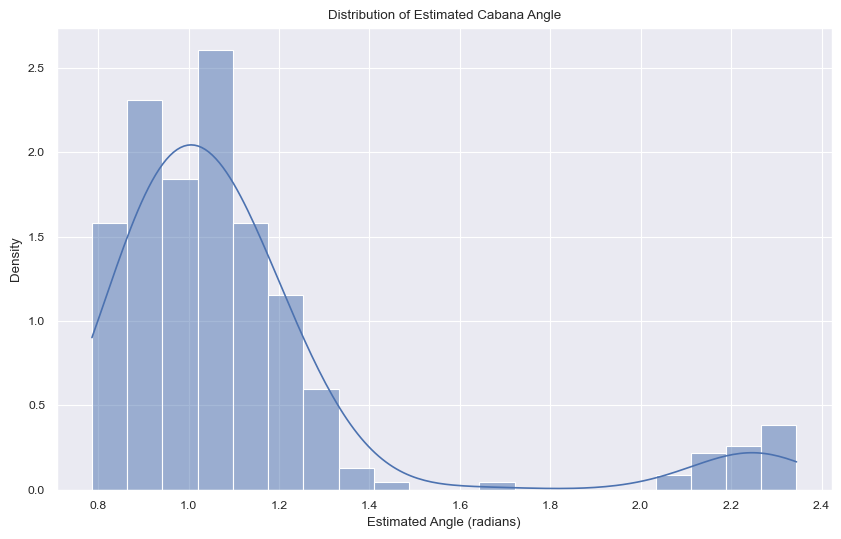

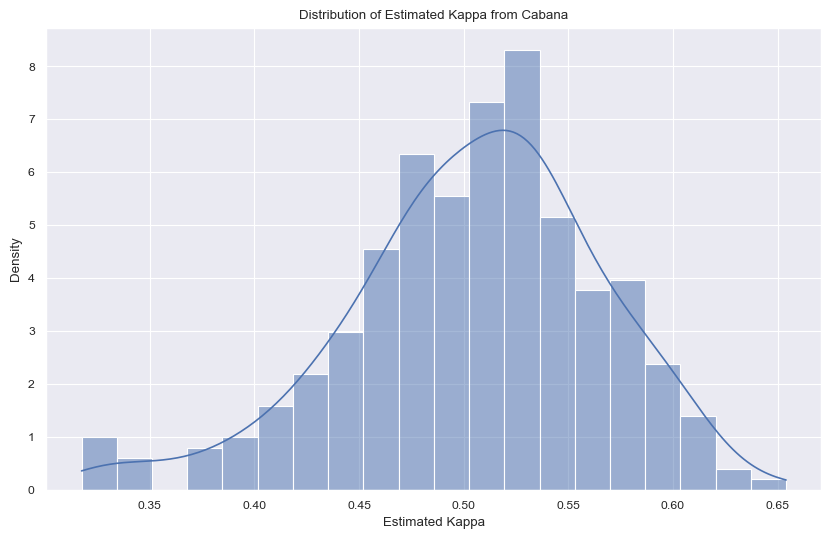

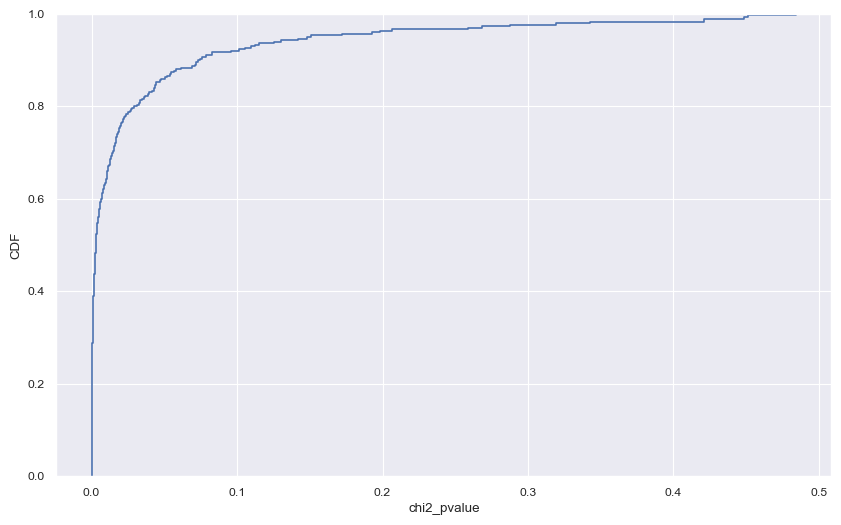

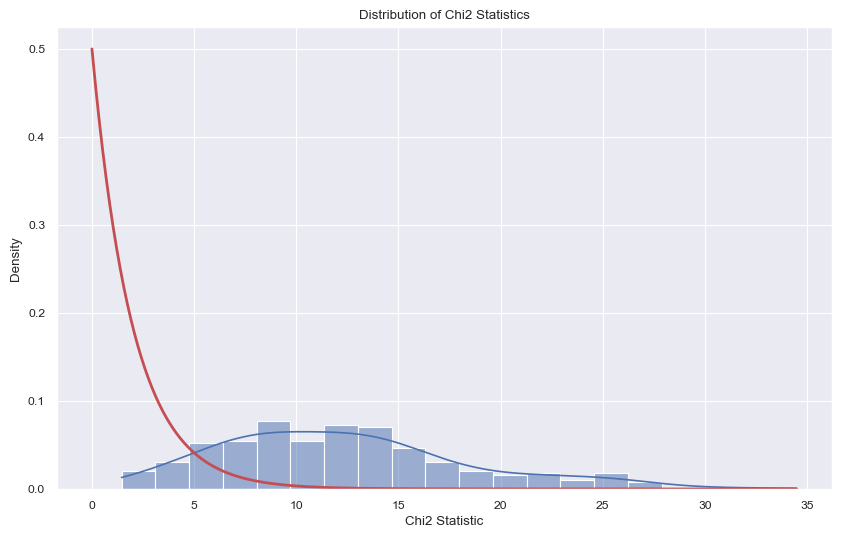

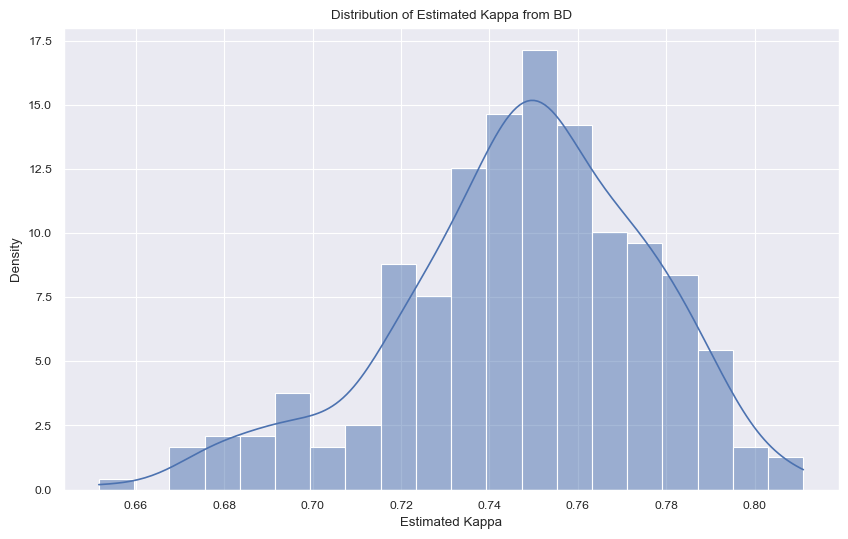

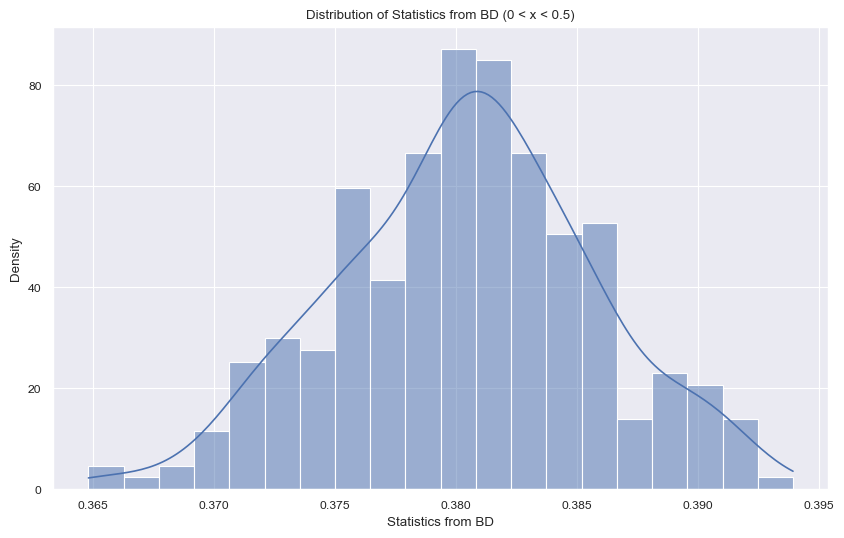

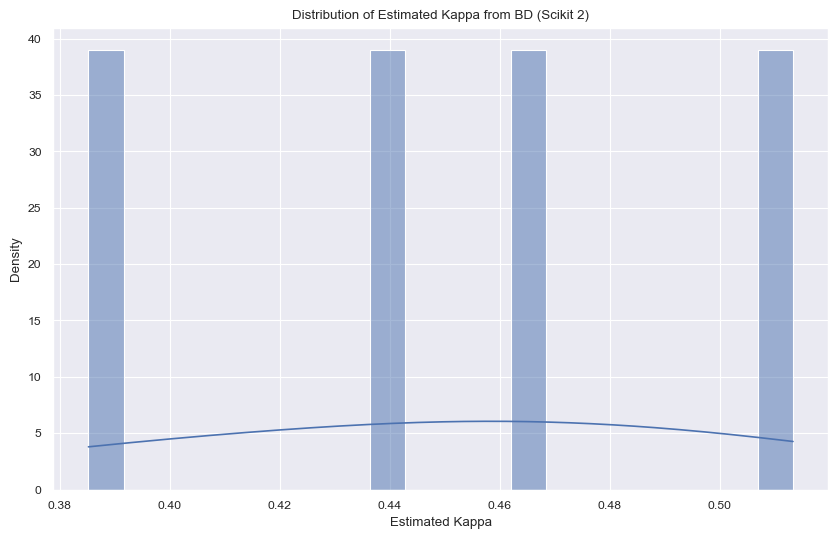

Mean statistics_BD:  0.4021580624180952
Median of statistics_BD:  0.3805785084670425


In [41]:
# Plot the distribution of Cabana angle estimates
plt.figure(figsize=(10, 6))
sns.histplot(results_df['estimated_angle_cabana'].dropna(), kde=True, stat="density", bins=20)
plt.title('Distribution of Estimated Cabana Angle')
plt.xlabel('Estimated Angle (radians)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot the distribution of Cabana κ estimates
plt.figure(figsize=(10, 6))
sns.histplot(results_df['estimated_kappa_cabana'].dropna(), kde=True, stat="density", bins=20)
plt.title('Distribution of Estimated Kappa from Cabana')
plt.xlabel('Estimated Kappa')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot the empirical CDF of χ^2 p-values
plt.figure(figsize=(10, 6))
sns.ecdfplot(results_df['chi2_pvalue'].dropna())
#sns.ecdfplot(1- chi2.cdf(results_df['chi2_statistic'].dropna(), df=2), label='Theoretical CDF')
#plt.title('CDF P-Values')
#plt.xlabel(f'$\alpha$')
plt.ylabel('CDF')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(results_df['chi2_statistic'].dropna(), kde=True, stat="density", bins=20)
x = np.linspace(0, results_df['chi2_statistic'].max(), 200)
plt.plot(x, chi2.pdf(x, df=2), 'r-', lw=2, label='Theoretical Chi2 (df=2)')
plt.title('Distribution of Chi2 Statistics')
plt.xlabel('Chi2 Statistic')
plt.ylabel('Density')
plt.grid(True)
plt.show()




# Plot the distribution of Biermé-Desolneux κ estimates
plt.figure(figsize=(10, 6))
sns.histplot(results_df['estimated_kappa_BD'].dropna(), kde=True, stat="density", bins=20)
plt.title('Distribution of Estimated Kappa from BD')
plt.xlabel('Estimated Kappa')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot the distribution of Biermé-Desolneux statistics (restricted range)
plt.figure(figsize=(10, 6))
sns.histplot(results_df['statistics_BD'][(results_df['statistics_BD'] > 0) & (results_df['statistics_BD'] < 0.5)].dropna(), kde=True, stat="density", bins=20)
plt.title('Distribution of Statistics from BD (0 < x < 0.5)')
plt.xlabel('Statistics from BD')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot κ estimates derived from Euler characteristic (connectivity = 2)
plt.figure(figsize=(10, 6))
sns.histplot(results_df['estimated_kappa_BD_scikit_2'].dropna(), kde=True, stat="density", bins=20)
plt.title('Distribution of Estimated Kappa from BD (Scikit 2)')
plt.xlabel('Estimated Kappa')
plt.ylabel('Density')
plt.grid(True)
plt.show()

print("Mean statistics_BD: ", results_df['mean_statistics_BD'].mean())
print("Median of statistics_BD: ", results_df['statistics_BD'].median())

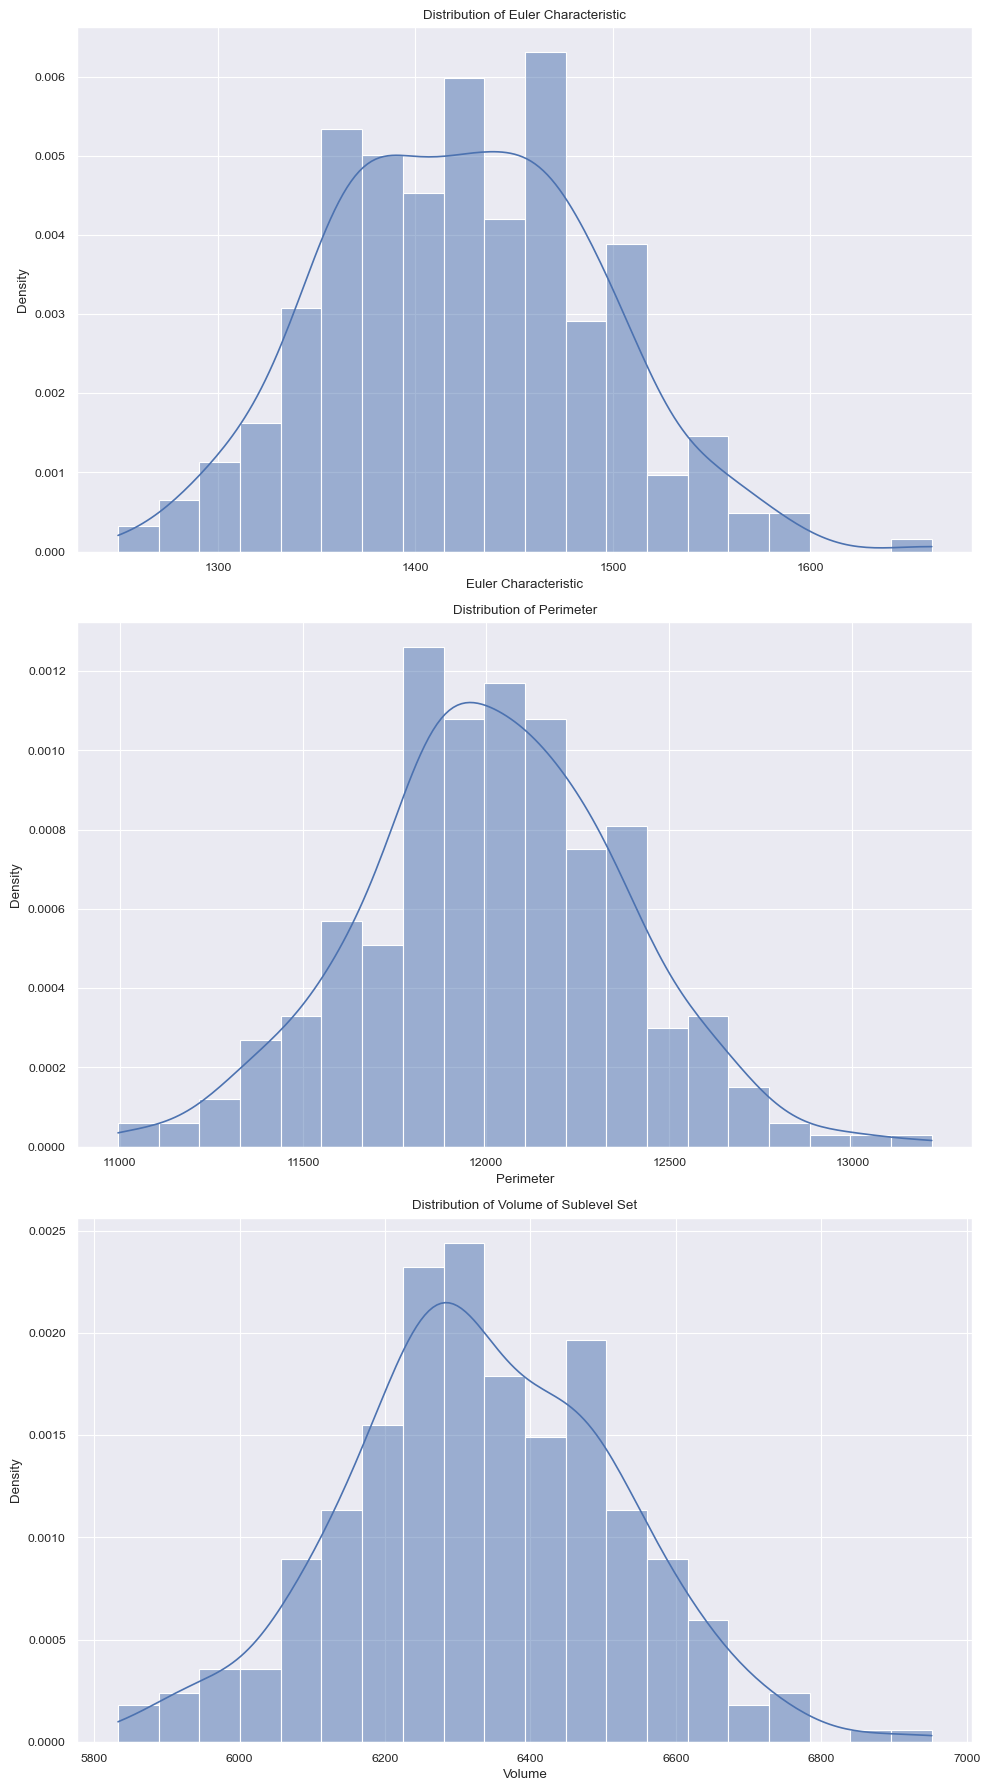

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Plot the distribution of Euler characteristic estimates
sns.histplot(results_df['euler_characteristic'].dropna(), kde=True, stat="density", bins=20, ax=axes[0])
axes[0].set_title('Distribution of Euler Characteristic')
axes[0].set_xlabel('Euler Characteristic')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Plot the distribution of contour perimeters
sns.histplot(results_df['perimeter'].dropna(), kde=True, stat="density", bins=20, ax=axes[1])
axes[1].set_title('Distribution of Perimeter')
axes[1].set_xlabel('Perimeter')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Plot the distribution of sublevel-set areas
sns.histplot(results_df['volume_sublevel_set'].dropna(), kde=True, stat="density", bins=20, ax=axes[2])
axes[2].set_title('Distribution of Volume of Sublevel Set')
axes[2].set_xlabel('Volume')
axes[2].set_ylabel('Density')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [43]:
import datetime

# Capture the current timestamp
current_date = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
# Alternative timestamp format example
# current_date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# Build a unique filename to avoid collisions

# Compose the dated filename
csv_filename = f'results/simulation_results_{current_date}.csv'

# Persist results_df to disk as CSV
results_df.to_csv(csv_filename, index=False)
print(f"Results DataFrame saved to {csv_filename}")

Results DataFrame saved to results/simulation_results_20251106154920.csv


In [44]:
# Compute gradient fields for the current gsfield (generate one if missing)
try:
    _ = gsfield.shape
    has_gsfield = True
except NameError:
    has_gsfield = False

if not has_gsfield:
    # Generate a single field with current parameters if none is cached
    x_coords = y_coords = range(field_size)
    model = gs.Gaussian(dim=2, var=1, len_scale=gstools_model_len_scale, angles=angle_rad, rescale=gstools_model_rescale_factor)
    srf = gs.SRF(model)
    gsfield = srf((x_coords, y_coords), mesh_type='structured')
    print("Generated a fresh gsfield for gradient demo.")

# Physical spacing per pixel
spacing = float(gstools_model_rescale_factor)  # equals 1 / unit_length
grad_x, grad_y = compute_gradient_field(gsfield, spacing=spacing)
print("Gradient fields computed:", grad_x.shape, grad_y.shape)
print("grad_x: mean={:.4f}, std={:.4f}".format(np.nanmean(grad_x), np.nanstd(grad_x)))
print("grad_y: mean={:.4f}, std={:.4f}".format(np.nanmean(grad_y), np.nanstd(grad_y)))

# Optional: empirical covariance across the grid
G = np.column_stack((grad_x.ravel(), grad_y.ravel()))
# Drop any rows containing NaNs before computing covariance
G = G[~np.isnan(G).any(axis=1)]
if len(G) > 1:
    covG = np.cov(G, rowvar=False)
    print("Empirical covariance of ∇Z (phys units):")
    print(covG)
else:
    print("Not enough points for covariance.")

Gradient fields computed: (1000, 1000) (1000, 1000)
grad_x: mean=0.0008, std=0.9944
grad_y: mean=-0.0000, std=1.0738
Empirical covariance of ∇Z (phys units):
[[ 0.98885602 -0.12243293]
 [-0.12243293  1.15310898]]


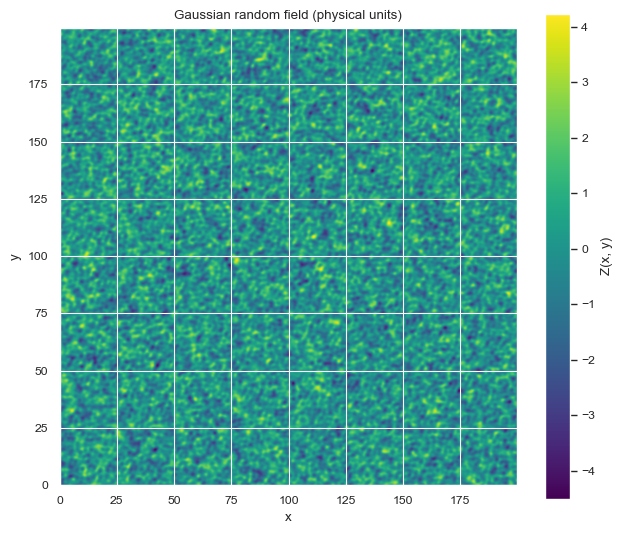

[[-1.30281799  0.66522227  0.22819523 ...  0.38918381  0.77883543
   1.49761813]
 [-1.2276272  -2.07942975  0.83968309 ... -0.35754783  0.55088441
   0.20122377]
 [-0.46762229 -1.61302986  1.00583863 ... -1.02809771 -1.13941315
   2.34636042]
 ...
 [ 0.95902121 -0.11771848  0.09352664 ...  1.05167471  0.13873561
  -0.23326266]
 [ 0.01441728  1.54981347 -1.65237733 ...  1.25101017 -0.02600052
  -0.09988131]
 [-0.31622368  0.51449884 -1.73903215 ...  0.57353532  0.78250176
  -0.44412521]]


/var/folders/k2/mf0jqmf15635bbb9j41fz41w0000gq/T/ipykernel_1414/3204249159.py:65: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.tight_layout()
/Users/decastro/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


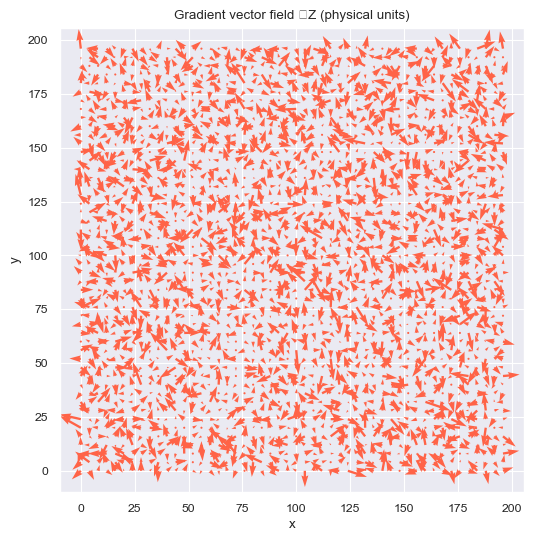

In [45]:
# Visualize the random field alongside its gradient vectors
try:
    _ = gsfield.shape
    has_gsfield = True
except NameError:
    has_gsfield = False

if not has_gsfield:
    x_coords = y_coords = range(field_size)
    model = gs.Gaussian(dim=2, var=1, len_scale=gstools_model_len_scale, angles=angle_rad, rescale=gstools_model_rescale_factor)
    srf = gs.SRF(model)
    gsfield = srf((x_coords, y_coords), mesh_type='structured')
    print("Generated a fresh gsfield for plotting.")

# Compute the gradient arrays if they are missing
try:
    _ = grad_x.shape; _ = grad_y.shape
except NameError:
    spacing = float(gstools_model_rescale_factor)
    grad_x, grad_y = compute_gradient_field(gsfield, spacing=spacing)

# Physical coordinates (consistent with gstools_model_rescale_factor)
ny, nx = gsfield.shape
spacing = float(gstools_model_rescale_factor)
x_phys = np.arange(nx) * spacing
y_phys = np.arange(ny) * spacing

# 1) Plot the scalar Gaussian field
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5.5))
im = ax.imshow(
    gsfield, origin='lower',
    extent=[x_phys[0], x_phys[-1], y_phys[0], y_phys[-1]],
    cmap='viridis', aspect='equal'
)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Z(x, y)')
ax.set_title('Gaussian random field (physical units)')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.tight_layout()
plt.show()

# 2) Plot the gradient vector field via quiver
# Subsample the grid for readability
stride = max(1, int(max(nx, ny) // 50))
X, Y = np.meshgrid(x_phys, y_phys)
subX = X[::stride, ::stride]
subY = Y[::stride, ::stride]
subGx = grad_x[::stride, ::stride]
subGy = grad_y[::stride, ::stride]
print(subGx)
mag = np.hypot(subGx, subGy)
max_mag = np.nanpercentile(mag, 99) if np.isfinite(mag).any() else 1.0
scale_val = max(1e-9, max_mag * 10.0)  # Scale arrows to roughly half the max magnitude
fig, ax = plt.subplots(1, 1, figsize=(6.5, 5.5))
ax.quiver(
    subX, subY, subGx, subGy,
    color='tomato', angles='xy', scale_units='xy', scale=0.01*scale_val,
    width=0.005
 )
ax.set_title('Gradient vector field ∇Z (physical units)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()